# **Análisis de la amenaza a sequía en escenarios históricos y actuales de transformación de las coberturas naturales en cuencas aledañas al PNN Chinganza**

## Preparación y caracterización de los datos

**Importar librerias**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask
import pyproj

**Cargar Dataset**

In [2]:
psig_root=r"C:/Users/Leydi/Documents/PSIG/data/ProyectoFinalSIG/"
AE = gpd.read_file(psig_root+'Area_Estudio/Area_Estudio_ProgSIG.shp')
AE_UAH_SC1 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC1.shp')
AE_UAH_SC2 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC2.shp')
AE_UAH_SC3 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC3.shp')
AE_UAH_SC4 = gpd.read_file(psig_root+'Estres_Hidrico/AE_HUA_SC4.shp')
Eco_ae = gpd.read_file(psig_root+'Eco_AE.shp')
PNN_chingaza = gpd.read_file(psig_root+'PNN/PNN_Chingaza.shp') 

El área de estudio corresponde a cinco subzonas hidrografías aledaña y de influencia directa al PNN Chingaza: Río Guatiquía, Río Humea, Río Guacavía, Rio Guavio y Río Guayuriba, todas pertenecen al departamento del Meta


In [3]:
AE.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID_1  5 non-null      int32   
 1   COD_AH      5 non-null      int32   
 2   COD_ZH      5 non-null      int32   
 3   COD_SZH     5 non-null      int32   
 4   NOM_AH      5 non-null      object  
 5   NOM_ZH      5 non-null      object  
 6   NOM_SZH     5 non-null      object  
 7   Shape_Leng  5 non-null      float64 
 8   Shape_Area  5 non-null      float64 
 9   RULEID      5 non-null      int32   
 10  Area_Ha     5 non-null      float64 
 11  geometry    5 non-null      geometry
dtypes: float64(3), geometry(1), int32(5), object(3)
memory usage: 512.0+ bytes


In [4]:
AE.loc[:, ['NOM_ZH', 'NOM_SZH']]

,NOM_ZH,NOM_SZH
0,Meta,Río Guatiquía
1,Meta,Río Humea
2,Meta,Río Guacavía
3,Meta,Río Guavio
4,Meta,Río Guayuriba


<Axes: >

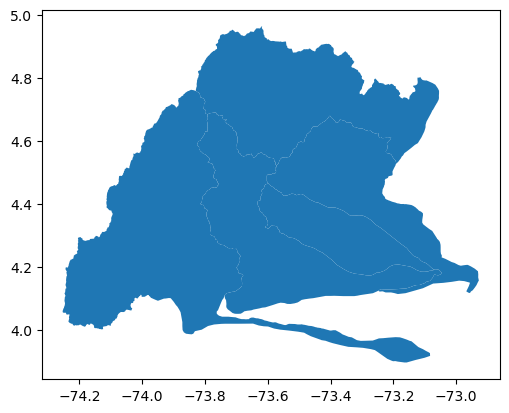

In [5]:
AE.plot()

Se reproyrectan las capas tanto para mejorar su visualización como para los análisis siguientes

In [6]:
AE.crs.is_geographic

True

In [7]:
AE_proj= AE.to_crs(9377)
print("AE reproyectado:", AE_proj.crs)

AE reproyectado: EPSG:9377


In [8]:
PNN_chingaza.crs.is_geographic

True

In [9]:
PNN_chingaza_proj= PNN_chingaza.to_crs(9377)
print("PNN_chingaza_proj reproyectado:", PNN_chingaza_proj.crs)

PNN_chingaza_proj reproyectado: EPSG:9377


Se visualiza el contexto del Parque Nacional Natural Chingaza con respecto al área del estudio

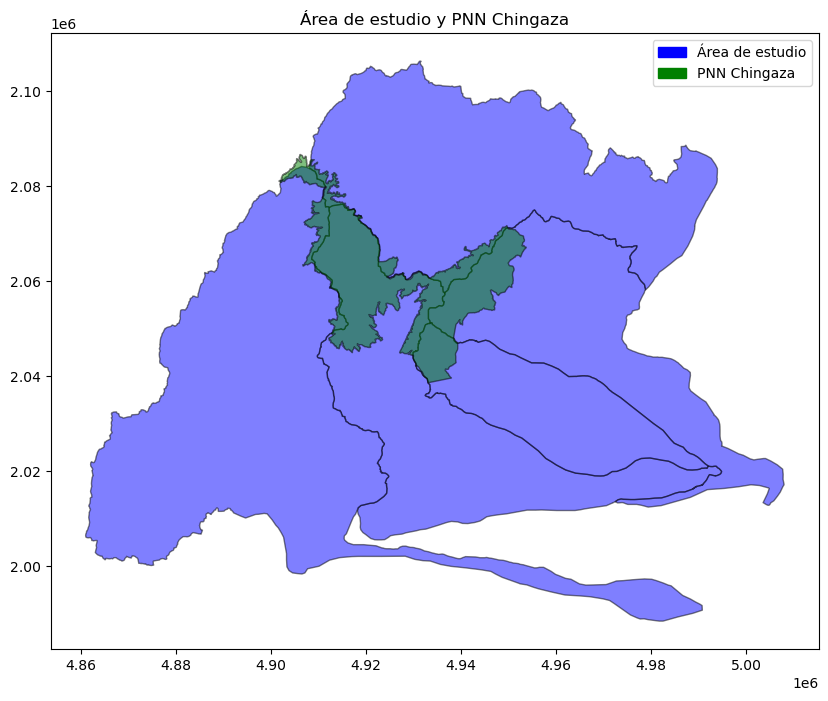

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
AE_proj.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5, label="Área de estudio")
PNN_chingaza_proj.plot(ax=ax, color="green", edgecolor="black", alpha=0.5, label="PNN Chingaza")
leyenda_AE = mpatches.Patch(color="blue", label="Área de estudio")
leyenda_PNN_chingaza = mpatches.Patch(color="green", label="PNN Chingaza")
plt.legend(handles=[leyenda_AE, leyenda_PNN_chingaza])
plt.title("Área de estudio y PNN Chingaza")
plt.show()

In [11]:
Eco_ae_proj = Eco_ae.to_crs(9377)
print("Eco_ae reproyectado:", Eco_ae_proj.crs)

Eco_ae reproyectado: EPSG:9377


In [12]:
Eco_ae_proj["area_ha"] = Eco_ae_proj.geometry.area / 10_000 
Eco_ae_proj["area_ha"] = Eco_ae_proj["area_ha"].round(2)

Se registran seis paisajes geomorfológicos en el área de estudio, siendo el paisaje mas representativo el de mosntaña

In [13]:
Eco_agg = Eco_ae_proj.groupby('PAISAJE')[['area_ha']].sum().reset_index()
Eco_agg

,PAISAJE,area_ha
0,Lomerio,32271.92
1,Montaña,668547.95
2,N.A.,37155.67
3,Piedemonte,119589.69
4,Planicie aluvial,68813.35
5,S.I.,1067.29
6,Valle,27022.65


In [14]:
Eco_ae_proj["PAISAJE"] = Eco_ae_proj["PAISAJE"].replace("N.A.", np.nan) 
Eco_ae_proj["PAISAJE"] = Eco_ae_proj["PAISAJE"].fillna("Rio")

<Axes: >

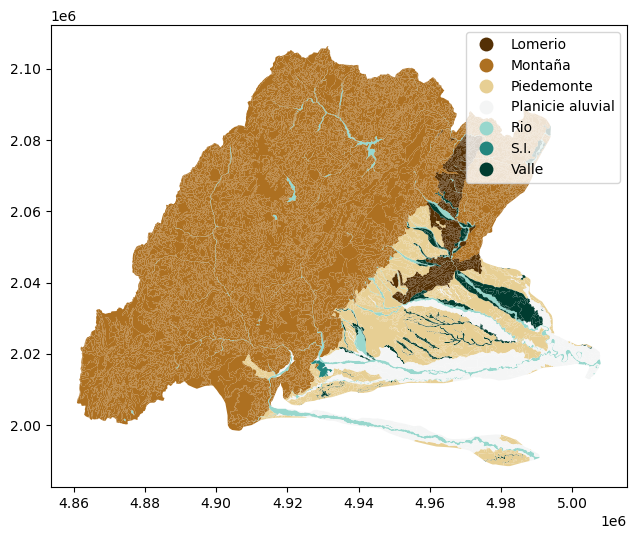

In [15]:
Eco_ae_proj.plot(column="PAISAJE", cmap="BrBG", legend=True, figsize=(10,6))

**Información hidrológica de la dinámica de caudales del modelo de Análisis Hidrológico realizado por Nogales et al, 2012 en su estudio “Hydrological Modeling for Multifunctional Landscape Planning in the Orinoquia Region of Colombia”.**

La unidad de análisis del modelo son UAH (Unidad de Análisis hidrológico) que comprende el área del acople de la cuenca superficial y el acuífero subterránea o misma unidad hidrogeológica. 
Con el modelo estima:

-El proceso de lluvia-escorrentía mediante el cálculo de la precipitación + evapotranspiración + recarga = escorrentía directa = cambio en el almacenamiento de uso
-La interacción rio-llanura de inundación 
-Procesos antrópicos de extracción de agua subterránea y superficial (agricultura, ganadería, doméstico, hidrocarburos, minería)
Luego generan cuatro escenarios de transformación del uso del agua para la región de la Orinoquia colombiana: 

**Escenario 1**
Puede considerarse como “seguir como siempre”, lo que representa una expansión modesta que se genera de manera óptima en términos de maximizar los beneficios agrícolas. Define una expansión del 1,51% de la palma aceitera, del 0,12% del arroz, del 0,08% de la silvicultura y del 0,04% de la soja.

_Para todas las capas de escenarios se reproyectar para luego calcular el área en hectáreas para cada intervalo de la variación de los caudales. La columna que contiene intervalo de la variación de caudal se convierte en una lista de números y luego se separa el valor máximo y mínimo para poder visualizar sus valores_ 

In [16]:
AE_UAH_SC1_proj= AE_UAH_SC1.to_crs(9377)
print("AE_UAH_SC1_proj:", AE_UAH_SC1_proj.crs)

AE_UAH_SC1_proj: EPSG:9377


In [17]:
AE_UAH_SC1_proj['numeros_lista_SC1'] = AE_UAH_SC1_proj['SC1_BAU_Rn'].str.findall(r'-?\d+')
AE_UAH_SC1_proj['numeros_lista_SC1'] = AE_UAH_SC1_proj['numeros_lista_SC1'].apply(lambda x: [int(num) for num in x])
n_expan_SC1 = pd.DataFrame(AE_UAH_SC1_proj['numeros_lista_SC1'].to_list(), index=AE_UAH_SC1_proj.index)
AE_UAH_SC1_proj = AE_UAH_SC1_proj.join(n_expan_SC1)
AE_UAH_SC1_proj = AE_UAH_SC1_proj.rename(columns={0: 'Max', 1: 'Min'})

In [18]:
AE_UAH_SC1_proj["area_ha"] = AE_UAH_SC1_proj.geometry.area / 10_000 
AE_UAH_SC1_proj["area_ha"] = AE_UAH_SC1_proj["area_ha"].round(2)

In [19]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC1_proj.at[18, 'Min'] = 100
AE_UAH_SC1_proj.at[19, 'Min'] = 0

**Escenario 2**
Representa la visión de los pequeños agricultores, ganaderos y la industria agrícola en la región de la Orinoquia colombiana. Este escenario estableció que el 14,27% del paisaje se convertiría en agricultura dividiendo el área equitativamente entre los cinco productos básicos (palma aceitera, arroz, silvicultura, soja y pastos para el ganado).

In [20]:
AE_UAH_SC2_proj= AE_UAH_SC2.to_crs(9377)
print("AE_UAH_SC2_proj:", AE_UAH_SC2_proj.crs)

AE_UAH_SC2_proj: EPSG:9377


In [21]:
AE_UAH_SC2_proj['numeros_lista_SC2'] = AE_UAH_SC2_proj['SC2_Stkhol'].str.findall(r'-?\d+')
AE_UAH_SC2_proj['numeros_lista_SC2'] = AE_UAH_SC2_proj['numeros_lista_SC2'].apply(lambda x: [int(num) for num in x])
n_expan_SC2 = pd.DataFrame(AE_UAH_SC2_proj['numeros_lista_SC2'].to_list(), index=AE_UAH_SC2_proj.index)
AE_UAH_SC2_proj = AE_UAH_SC2_proj.join(n_expan_SC2)
AE_UAH_SC2_proj = AE_UAH_SC2_proj.rename(columns={0: 'Max', 1: 'Min'})

In [22]:
AE_UAH_SC2_proj["area_ha"] = AE_UAH_SC2_proj.geometry.area / 10_000 
AE_UAH_SC2_proj["area_ha"] = AE_UAH_SC2_proj["area_ha"].round(2)

In [23]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC2_proj.at[16, 'Min'] = 100
AE_UAH_SC2_proj.at[17, 'Min'] = 0

**Escenario 3** 
Representa la visión del gobierno colombiano descrita en el Plan Maestro ( DNP, 2016 ), que busca maximizar la tierra subutilizada para la agricultura. Este escenario propone una expansión del 10,61% de la agricultura (que se dividiría equitativamente entre arroz y soja), el 13,53% de la ganadería, el 6,97% de la silvicultura y el 12,54% de los cultivos agroforestales (asignados a la palma aceitera).

In [24]:
AE_UAH_SC3_proj= AE_UAH_SC3.to_crs(9377)
print("AE_UAH_SC3_proj:", AE_UAH_SC3_proj.crs)

AE_UAH_SC3_proj: EPSG:9377


In [25]:
AE_UAH_SC3_proj['numeros_lista_SC3'] = AE_UAH_SC3_proj['SC3_Master'].str.findall(r'-?\d+')
AE_UAH_SC3_proj['numeros_lista_SC3'] = AE_UAH_SC3_proj['numeros_lista_SC3'].apply(lambda x: [int(num) for num in x])
n_expan_SC3 = pd.DataFrame(AE_UAH_SC3_proj['numeros_lista_SC3'].to_list(), index=AE_UAH_SC3_proj.index)
AE_UAH_SC3_proj = AE_UAH_SC3_proj.join(n_expan_SC3)
AE_UAH_SC3_proj = AE_UAH_SC3_proj.rename(columns={0: 'Max', 1: 'Min'})

In [26]:
AE_UAH_SC3_proj["area_ha"] = AE_UAH_SC3_proj.geometry.area / 10_000 
AE_UAH_SC3_proj["area_ha"] = AE_UAH_SC3_proj["area_ha"].round(2)

In [27]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC3_proj.at[15, 'Min'] = 100

**Escenario 4**
Representa una visión extrema en la que toda la frontera agrícola está ocupada incluso si es un área protegida. Este escenario propone un 53,68% de expansión de toda la actividad productiva (palma aceitera, arroz, forestación, soja y pasturas para ganadería).

In [28]:
AE_UAH_SC4_proj= AE_UAH_SC4.to_crs(9377)
print("AE_UAH_SC4_proj:", AE_UAH_SC4_proj.crs)

AE_UAH_SC4_proj: EPSG:9377


In [29]:
AE_UAH_SC4_proj['numeros_lista_SC4'] = AE_UAH_SC4_proj['SC4_AgriFt'].str.findall(r'-?\d+')
AE_UAH_SC4_proj['numeros_lista_SC4'] = AE_UAH_SC4_proj['numeros_lista_SC4'].apply(lambda x: [int(num) for num in x])
n_expan_SC4 = pd.DataFrame(AE_UAH_SC4_proj['numeros_lista_SC4'].to_list(), index=AE_UAH_SC4_proj.index)
AE_UAH_SC4_proj = AE_UAH_SC4_proj.join(n_expan_SC4)
AE_UAH_SC4_proj = AE_UAH_SC4_proj.rename(columns={0: 'Max', 1: 'Min'})

In [30]:
AE_UAH_SC4_proj["area_ha"] = AE_UAH_SC4_proj.geometry.area / 10_000 
AE_UAH_SC4_proj["area_ha"] = AE_UAH_SC4_proj["area_ha"].round(2)

In [31]:
# Modificar NaN que representan valores >100, o 0 tanto en su rango maximi como minimo 
AE_UAH_SC4_proj.at[15, 'Min'] = 100
AE_UAH_SC4_proj.at[16, 'Min'] = 0

**Se grafica los escenarios en el cambio de los caudales en su nivel Max: el gradiente va desde la disminución de 100 % o el aumento del 100 % o mas (<100) del caudal en cada UAH**

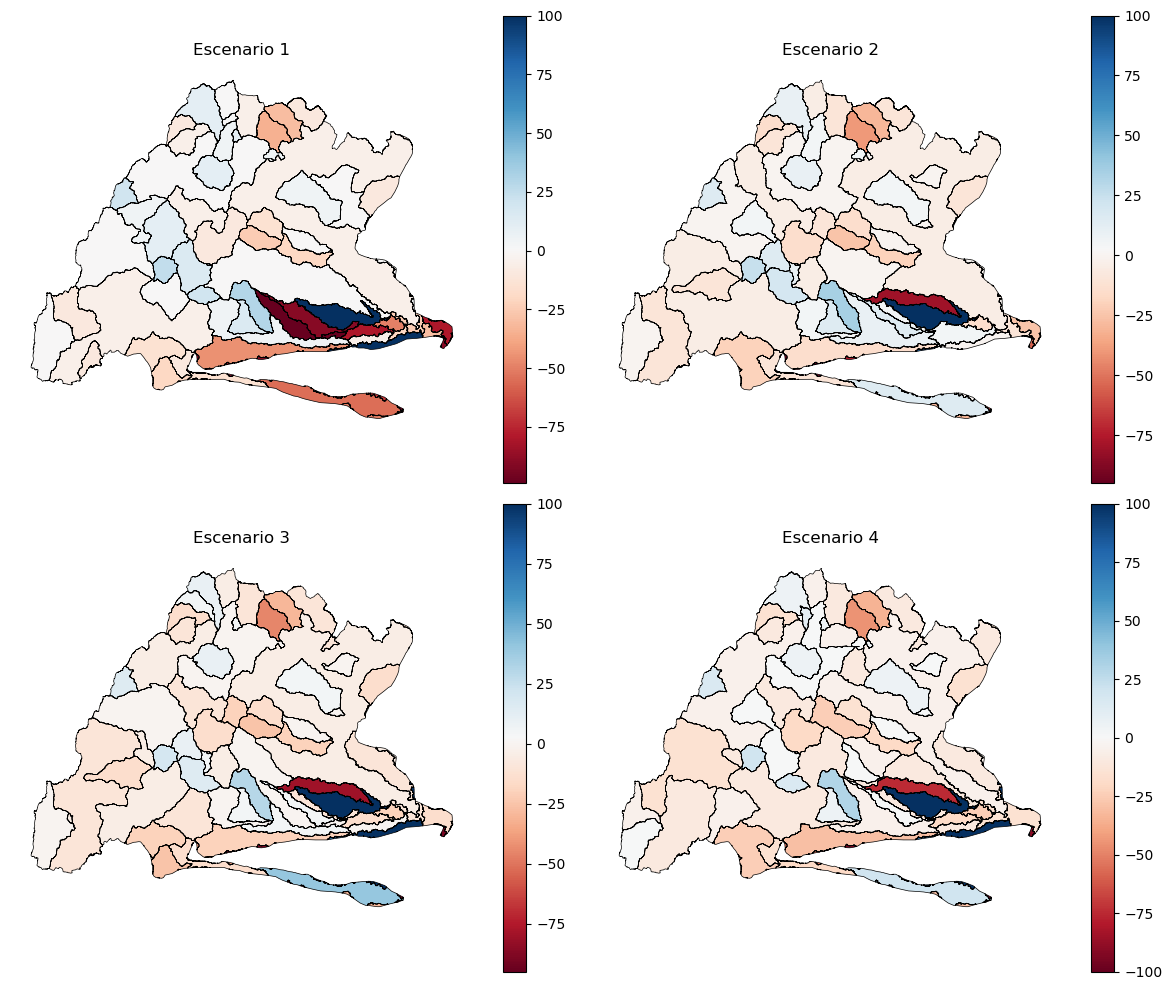

In [32]:
# Crear la figura y los subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 filas, 2 columnas
capas = [AE_UAH_SC1_proj, AE_UAH_SC2_proj, AE_UAH_SC3_proj, AE_UAH_SC4_proj]
titulos = ["Escenario 1", "Escenario 2", "Escenario 3", "Escenario 4"]

# Iterar sobre los ejes y graficar cada capa con la variable "Max"
for i, (gdf, ax) in enumerate(zip(capas, axes.flat)):
    gdf.plot(column="Max",  # Maximo valor del intervalo de caudal
             cmap="RdBu",  
             edgecolor="black",
             linewidth=0.5,
             legend=True,
             ax=ax)
    ax.set_title(titulos[i])  
    ax.axis("off")  

#Ajustar espacio entre gráficos
plt.tight_layout()
plt.show()

**Se grafica los escenarios en el cambio de los caudales en su nivel Max: el gradiente va desde la disminución de 100 % o el aumento del 100 % o mas (<100) del caudal en cada UAH que hacen parte del PNN chingaza**

In [33]:
PNN_UAH_SC1_proj = gpd.clip(AE_UAH_SC1_proj, PNN_chingaza_proj)
PNN_UAH_SC2_proj = gpd.clip(AE_UAH_SC2_proj, PNN_chingaza_proj)
PNN_UAH_SC3_proj = gpd.clip(AE_UAH_SC3_proj, PNN_chingaza_proj)
PNN_UAH_SC4_proj = gpd.clip(AE_UAH_SC4_proj, PNN_chingaza_proj)

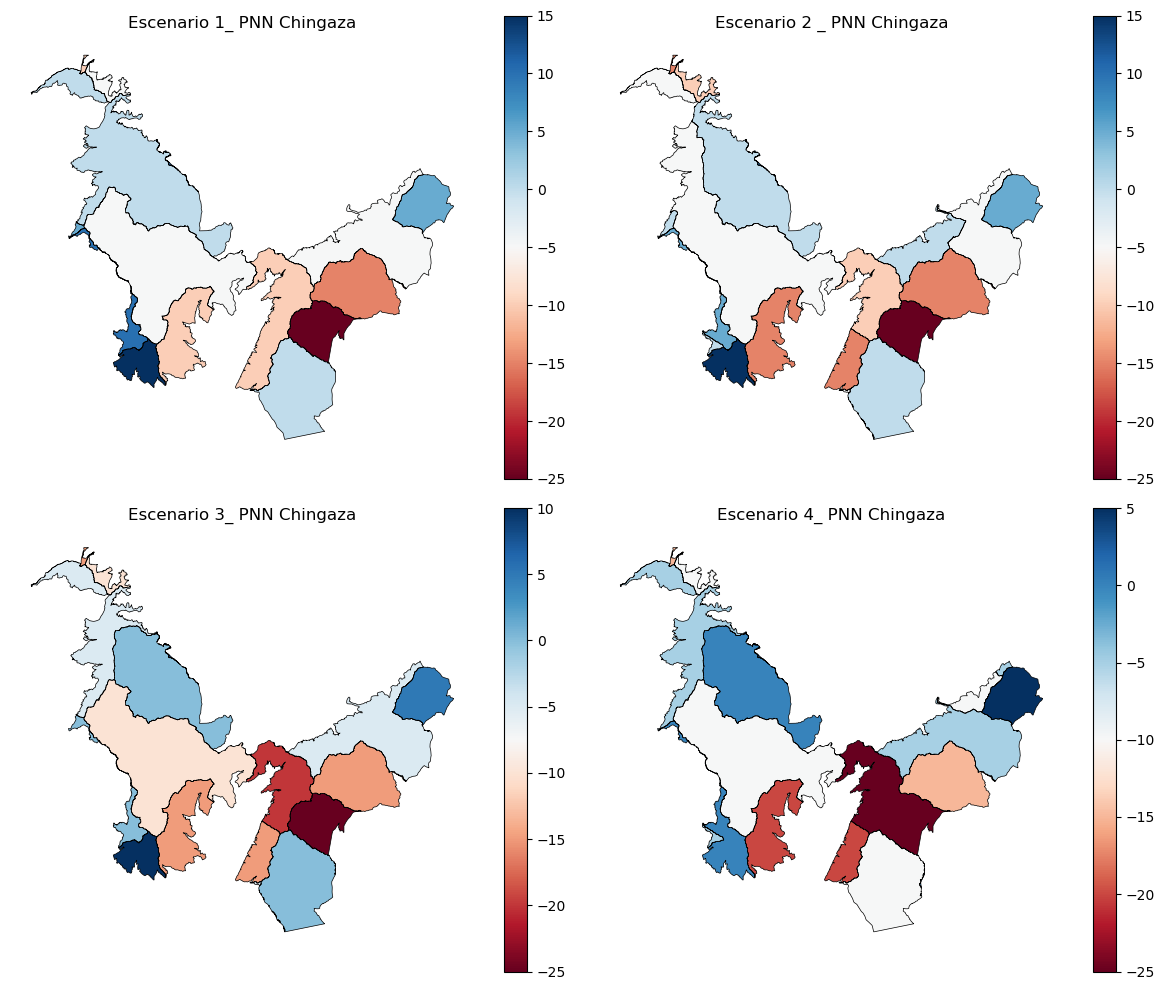

In [34]:
# Crear la figura y los subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 filas, 2 columnas
capas_pnn = [PNN_UAH_SC1_proj, PNN_UAH_SC2_proj, PNN_UAH_SC3_proj, PNN_UAH_SC4_proj]
titulos_pnn = ["Escenario 1_ PNN Chingaza", "Escenario 2 _ PNN Chingaza", "Escenario 3_ PNN Chingaza", "Escenario 4_ PNN Chingaza"]

# Iterar sobre los ejes y graficar cada capa con la variable "Max"
for i, (gdf, ax) in enumerate(zip(capas_pnn, axes.flat)):
    gdf.plot(column="Max",  # Maximo valor del intervalo de caudal
             cmap="RdBu",  
             edgecolor="black",
             linewidth=0.5,
             legend=True,
             ax=ax)
    ax.set_title(titulos_pnn[i])  
    ax.axis("off")  

#Ajustar espacio entre gráficos
plt.tight_layout()
plt.show()

En el área de estudio que comprende las cinco cuencas hidrográficas aledañas al parque presentan con un rango de disminución máxima del caudal de hasta 95 % o 100 % en los cuatro escenarios. Mientras que la disminución máxima en el área protegida es de 25%